In [1]:
int(0b000100)

4

(<matplotlib.text.Text at 0x7ff0470e2610>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

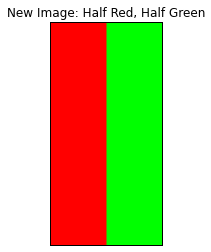

In [2]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import util

# create image
height,width = 400, 200
img = np.zeros((height,width,3), np.uint8)

img[:,0:0.5*width] = (255,0,0) 
img[:,0.5*width:width] = (0,255,0)

plt.imshow(img)
plt.title('New Image: Half Red, Half Green'), plt.xticks([]), plt.yticks([])

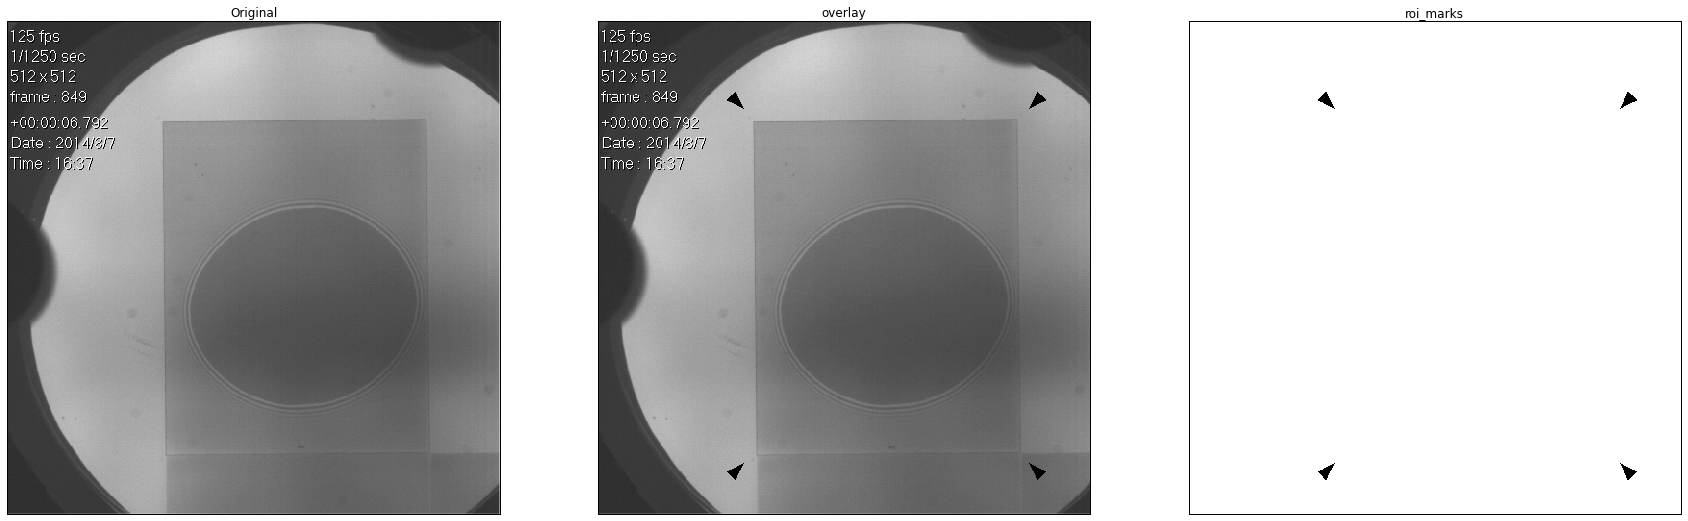

In [3]:
img = cv2.imread('/data/projects/contact_front/EFF/ContactFront-040.png',cv2.IMREAD_GRAYSCALE)
rows, cols = img.shape

roi_marks = cv2.imread('/data/images/ROI_markers.png',cv2.IMREAD_GRAYSCALE)

retval, thresh = cv2.threshold(roi_marks, 145, 200, cv2.THRESH_BINARY)
overlay = cv2.bitwise_and(img, roi_marks)


util.plot_imgs([(img,'Original'), (overlay, 'overlay'), (roi_marks, 'roi_marks')])

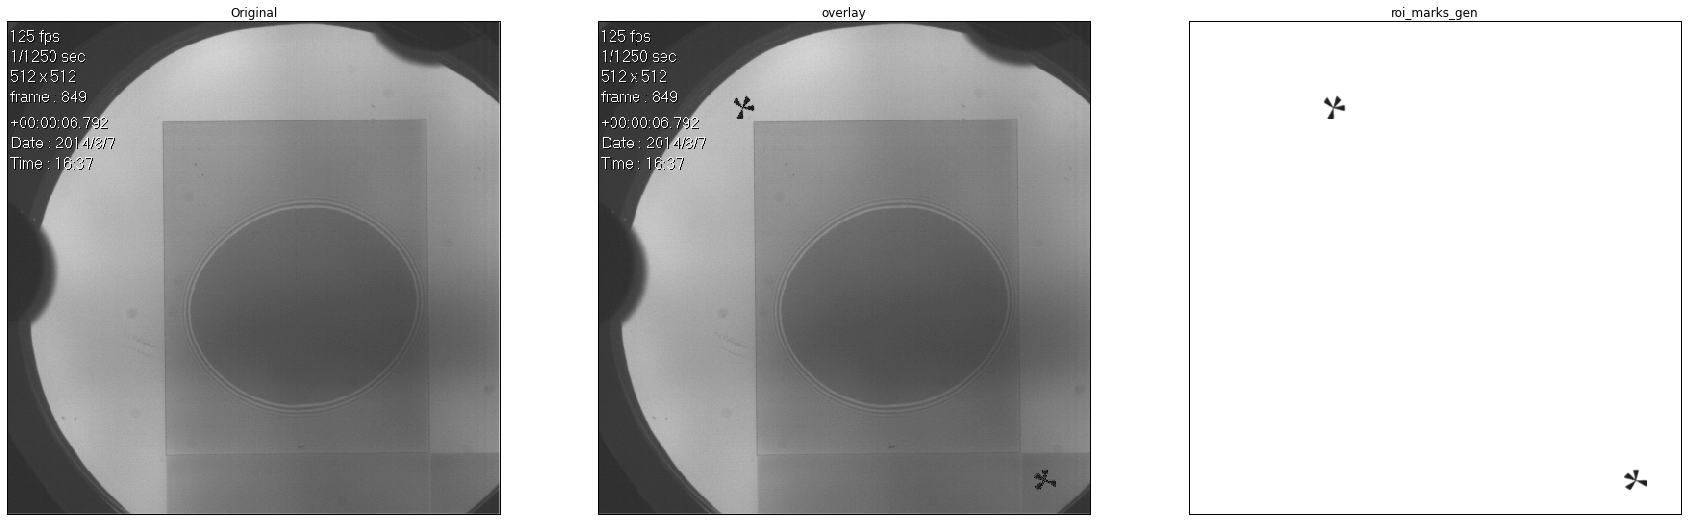

In [4]:
img = cv2.imread('/data/projects/contact_front/EFF/ContactFront-040.png',cv2.IMREAD_GRAYSCALE)
h, w = img.shape[:2]

uat = cv2.imread('/data/images/uat_24x24.png',cv2.IMREAD_GRAYSCALE)
uat_h, uat_w = uat.shape[:2]
# uat_lst = [uat]
# uat_lst.append(np.rot90(uat))
# uat_lst.append(np.rot90(uat_lst[-1]))
# uat_lst.append(np.rot90(uat_lst[-1]))

uat_lst = []
roi_marks_gen = np.full((h, w), 255, np.uint8)
#uat_locs = [(140,77), (452,77), (452,464), (140,464)]
uat_locs = [(140,77), (452,464)]
for idx, uat_loc in enumerate(uat_locs):
    roi_marks_gen[uat_loc[1]:uat_loc[1]+uat_h, uat_loc[0]:uat_loc[0]+uat_w] = uat
    uat_lst.append(uat)
    uat = np.rot90(uat)  # rotate for the next iter

overlay = cv2.bitwise_and(img, roi_marks_gen)

util.plot_imgs([(img,'Original'), (overlay, 'overlay'), (roi_marks_gen, 'roi_marks_gen')])

In [5]:
#template = cv2.imread('template.jpg',0)

# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
img_tmp = overlay.copy()

plots = []
for meth in methods:
    img_tmp = overlay.copy()
    method = eval(meth)

    res = cv2.matchTemplate(img_tmp, uat[0], method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
        
    res = cv2.matchTemplate(img_tmp, uat[1], method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img_tmp,top_left, bottom_right, 255, 2)

#     plt.subplot(121),plt.imshow(res,cmap = 'gray')
#     plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
#     plt.subplot(122),plt.imshow(img_tmp,cmap = 'gray')
#     plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
#     plt.suptitle(meth)
#     plt.show()

In [6]:
#template = cv2.imread('template.jpg',0)

# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
img_tmp = overlay.copy()

pts =[]
for uat in uat_lst:
    res = cv2.matchTemplate(img_tmp, uat, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    pt = (max_loc[0] + (uat_h/2), max_loc[1] + (uat_w/2))
    pts.append(pt)

print pts
cv2.rectangle(img_tmp, pts[0], pts[1], (0,0,255), 1)

img_roi = img[pts[0][1]:pts[1][1], pts[0][0]:pts[1][0]] #np slice: [startY:endY, startX:endX]

# res = cv2.matchTemplate(img_tmp, uat_marks, cv2.TM_CCOEFF_NORMED)
# threshold = 0.85
# loc = np.where( res >= threshold)

# for pt in zip(*loc[::-1]):
#     print pt
#     cv2.rectangle(img_tmp, pt, (pt[0] + w, pt[1] + h), (0,0,255), 1)

# cv2.rectangle(img_tmp,top_left, bottom_right, 255, 2)
slice_size = 40
top_left_slice = [(0,0), (slice_size, slice_size)]
bot_right_slice = [(w-slice_size,h-slice_size), (w-1,h-1)]

h, w = img_roi.shape[:2]
#top_left = img_roi[0:25, 0:25]
#bot_right = img_roi[-50:(h-1), -50:(w-1)]
top_left = img_roi[top_left_slice[0][1]:top_left_slice[1][1], top_left_slice[0][0]:top_left_slice[1][0]]
bot_right = img_roi[bot_right_slice[0][1]:bot_right_slice[1][1], bot_right_slice[0][0]:bot_right_slice[1][0]]

top_left = cv2.equalizeHist(top_left)
bot_right = cv2.equalizeHist(bot_right)

#print bot_right.shape

corners = cv2.goodFeaturesToTrack(top_left,1,0.1,300)
corners = np.int0(corners)
for i in corners:
    x,y = i.ravel()
    print x,y
    roi_top = y
    roi_left = x
    cv2.circle(top_left,(x,y),3,255,-1)

corners = cv2.goodFeaturesToTrack(bot_right,1,0.1,300)
corners = np.int0(corners)
for i in corners:
    x,y = i.ravel()
    print x,y
    roi_bot = y
    roi_left = x
    cv2.circle(bot_right,(x,y),3,255,-1)
    
img_roi_eq = cv2.equalizeHist(img_roi)

util.plot_imgs([(img_tmp,'UAT Locs'), (img_roi,'img_roi'), (img_roi_eq,'img_roi_eq'), 
                (top_left, 'top_left'), (bot_right, 'bot_right')])


[(152, 89), (464, 476)]
10 15


TypeError: long() argument must be a string or a number, not 'NoneType'

In [ ]:
w, h = img_roi.shape[::-1]
print w,h

hor_slice = img_roi_eq[(h/2)-25:(h/2)+25, 0:w-1]
vert_slice = img_roi_eq[0:h-1, (w/2)-25:(w/2)+25]
vert_slice = np.rot90(vert_slice)
util.plot_imgs([(hor_slice,'hor_slice'), (vert_slice,'vert_slice')])

hor_slice_processed = hor_slice
vert_slice_processed = vert_slice

hor_slice_diff = np.abs(np.diff(np.mean(hor_slice_processed, axis=0)))
vert_slice_diff = np.abs(np.diff(np.mean(vert_slice_processed, axis=0)))

plt.figure(figsize=(10*2,10*2))
plt.subplot(221)
plt.plot(hor_slice_diff)
plt.title('Horizontal Differential')
plt.subplot(222)
plt.plot(vert_slice_diff)
plt.title('Vertical Differential')

In [ ]:

fig = plt.figure(  )
plot = fig.add_subplot ( 111 )
 
# draw a cardinal sine plot
x = np.arange ( 0, 100, 0.1 )
y = np.sin ( x ) / x
plot.plot ( x, y )

plt_data = util.fig2data(fig)
print plt_data.shape

plt.imshow(plt_data)
# util.plot_imgs([plt_data, 'plt_data'], color=True)

In [ ]:
import imutils